In [9]:
import pygame, sys, random
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import pylab

num_episodes = 10

agentRadius = 10

# get size of state and action from environment

boundaryPos = [400, 590]
boundaryLength = [70, 70]
initPosAgent = [boundaryPos[0] + boundaryLength[0] / 2, boundaryPos[1] + boundaryLength[1] / 2]#[boundaryPos[0], boundaryPos[1] + boundaryLength[1]]
goalPos = [boundaryPos[0] + boundaryLength[0], boundaryPos[1]]

moveObstacles = True
action_size = 9
obsNumber = 2
# state_size = obsNumber * 2 + 1
state_size = 3
# state_size = obsNumber + 1

In [2]:
# A2C(Advantage Actor-Critic) agent
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.load_model = True
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.00002
        self.critic_lr = 0.00005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./Practice004_DataSave/Actor.h5")
            self.critic.load_weights("./Practice004_DataSave/Critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_normal'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='glorot_normal'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        # Policy = 확률. 이 확률에 맞게 Action을 선택
        print policy
        return np.random.choice(self.action_size, 1, p=policy)[0]
#         return policy

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

In [3]:
def ckWall(xPos, yPos):
    flagWall = 0
    if(xPos < boundaryPos[0]):
        xPos = boundaryPos[0]
        flagWall = -1
    elif(xPos > boundaryPos[0] + boundaryLength[0]):
        xPos = boundaryPos[0] + boundaryLength[0]
        flagWall = -1
    if(yPos < boundaryPos[1]):
        yPos = boundaryPos[1]
        flagWall = -1
    elif(yPos > boundaryPos[1] + boundaryLength[1]):
        yPos = boundaryPos[1] + boundaryLength[1]
        flagWall = -1
        
    return [xPos, yPos, flagWall]

In [4]:
def ckInit(initLoc, obsLoc):
    if math.sqrt((initLoc[0] - obsLoc[0])**2 + (initLoc[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        if initLoc[0] - obsLoc[0] < 0:
            obsLoc[0] += 1
        else:
            obsLoc[0] -= 1
        if initLoc[1] - obsLoc[1] < 0:
            obsLoc[1] += 1
        else:
            obsLoc[1] -= 1
    if math.sqrt((goalPos[0] - obsLoc[0])**2 + (goalPos[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        obsLoc[0] -= 1
        obsLoc[1] += 1
    return obsLoc

In [5]:
def stateGenerator(obsPosition, agtPosition, idx):
    returnSum = []
    returnSum = returnSum + [agtPosition[0] - obsPosition[idx][0], agtPosition[1] - obsPosition[idx][1]]
    returnSum = returnSum + [math.sqrt((agtPosition[0] - goalPos[0])**2 + (agtPosition[1] - goalPos[1])**2)]
    returnSum = np.reshape(returnSum, [1, 3])
    return returnSum

In [6]:
def ckCollision(obsPosition, agtPosition):
    for i in range(0,obsNumber):
        if math.sqrt((agtPosition[0] - obsPosition[i][0])**2 + (agtPosition[1] - obsPosition[i][1])**2) <= 20:
            return True
        else:
            return False

In [7]:
def takeAction(action):
    xAction = 0
    yAction = 0
    if action == 0:
        xAction = 1
    elif action == 1:
        xAction = 1
        yAction = 1
    elif action == 2:
        xAction = 1
        yAction = -1            
    elif action == 3:
        xAction = -1
        yAction = 1
    elif action == 4:
        xAction = -1
    elif action == 5:
        xAction = -1
        yAction = -1
    elif action == 6:
        yAction = -1
    elif action == 7:
        yAction = 1
    elif action  == 8:
        xAction = 0
        yAction = 0
        
    return [xAction, yAction]

In [15]:
pygame.init()
screen = pygame.display.set_mode([1280,960])
screen.fill([200, 200, 200])

# make A2C agent
agent = A2CAgent(state_size, action_size)

rList, episodes = [], []

# Make Obstacles (obsNumber)
obstaclePos = [[0, 0] for _ in range(obsNumber)]
for i in range(0,obsNumber):
    while True:
        obstaclePos[i][0] = boundaryPos[0] + random.randrange(1, boundaryLength[0])
        obstaclePos[i][1] = boundaryPos[1] + random.randrange(1, boundaryLength[1])
        if obstaclePos[i][0] <= goalPos[0] - agentRadius or obstaclePos[i][0] >= goalPos[0] + agentRadius:
            if obstaclePos[i][1] >= goalPos[1] + agentRadius or obstaclePos[i][1] <= goalPos[1] - agentRadius:
                if obstaclePos[i][0] <= initPosAgent[0] - agentRadius or obstaclePos[i][0] >= initPosAgent[0] + agentRadius:
                    if obstaclePos[i][1] >= initPosAgent[1] + agentRadius or obstaclePos[i][1] <= initPosAgent[1] - agentRadius:
                        break

for e in range(num_episodes):
    # Initialize
    done = False
    score = 0
    x = initPosAgent[0]#boundaryPos[0]
    y = initPosAgent[1]#boundaryPos[1]
    print("Episode ", e, "Starts!")
    #state = np.reshape(state, [1, state_size])
    tmpX = 0
    tmpY = 0
    while not done:
        getPolicy = []
#         tmpPolicyA = []
#         tmpPolicyB = []
        
        for i in range(0, obsNumber):
            state = stateGenerator(obstaclePos, [x,y], i)
#             [action, badAction] = agent.get_action(state)
#             tmpPolicyA = np.log(agent.get_action(state))
            action = agent.get_action(state)
#             if(i > 0):
#                 getPolicy = np.add(tmpPolicyA, getPolicy)
#                 getPolicy = np.multiply(tmpPolicyA, getPolicy)
#             else:
#                 getPolicy = tmpPolicyA
#             print("Local",i,":", tmpPolicyA)
#         getPolicy = np.exp(getPolicy)
#         getPolicy = getPolicy / sum(getPolicy)
#             action = np.random.choice(action_size, 1, p = getPolicy)[0]
#         print("Total:", getPolicy)
            
            xMove = 0
            yMove = 0

            [xMove, yMove] = takeAction(action)
            
#             tmpX = tmpX + xMove
#             tmpY = tmpY + yMove
            x = x + xMove
            y = y + yMove
            
            if ckCollision(obstaclePos, [x,y]) == True:
                print("Collision Predicted!")
                x = x - xMove
                y = y - yMove
            
            wallFlag = 0
            collisionFlag = 0
#         if tmpX != 0 or tmpY != 0:
#             x = int(round(x + tmpX / math.sqrt(tmpX**2 + tmpY**2)))
#             y = int(round(y + tmpY / math.sqrt(tmpX**2 + tmpY**2)))
        print "====================================================="
        [x, y, wallFlag] = ckWall(x,y)
        pygame.draw.circle(screen, [100, 100, 255], [x,y], 10, 0)
#         next_state = stateGenerator(obstaclePos, [x,y])

        if(math.sqrt((x - goalPos[0])**2 + (y - goalPos[1])**2) <= 20):
            print("Goal Reached!")           
            collisionFlag = 1
            done = 1
                
        for i in range(0,obsNumber):
            if moveObstacles:
                obstaclePos[i][0] = obstaclePos[i][0] + random.randrange(-1,2)
                obstaclePos[i][1] = obstaclePos[i][1] + random.randrange(-1,2)
                [obstaclePos[i][0], obstaclePos[i][1], _] = ckWall(obstaclePos[i][0], obstaclePos[i][1])
                obstaclePos[i] = ckInit(initPosAgent ,obstaclePos[i])

            pygame.draw.circle(screen, [255, 50 + 20*i, 50 + 20 * i], obstaclePos[i], 10, 0)
            if math.sqrt((x - obstaclePos[i][0])**2 + (y - obstaclePos[i][1])**2) <= 20:
                print("Collision!")
                collisionFlag = -1
                ObjectIndex = i
                done = True 
#         if wallFlag == -1:
#             done = True
            
        if not done:
            reward = -0.1
            if wallFlag == -1:
                reward = -1
        else:
            if collisionFlag == 1:
                reward = 10000
                rList.append(1)
            elif collisionFlag == -1:
                reward = -10000
                rList.append(0)
#             next_state, reward, done, ininitPosAgentfo = env.step(action)
#             next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
#             reward = reward if not done or score == 499 else -100
        
#         agent.train_model(state, action, reward, next_state, done)

        score += reward
#         state = next_state

        if done:
            # every episode, plot the play time

            episodes.append(e)
            pylab.plot(episodes, rList, 'b')
#             pylab.savefig("./Practice004_DataSave/ActorCriticGraph_Test.png")
        #circle(Surface, color, pos, radius, width=0)
        pygame.draw.circle(screen, [100,255,100], [goalPos[0],goalPos[1]], 10, 2)
        #rect(Surface, color, Rect, width=0)
        pygame.draw.rect(screen, [255,100,100],[boundaryPos[0] - agentRadius, boundaryPos[1] - agentRadius, boundaryLength[0] + agentRadius * 2, boundaryLength[1] + agentRadius * 2],2)
        pygame.display.flip()
        screen.fill([200,200,200])
    print score
    # save the model
#     if e % 50 == 0:
#         agent.actor.save_weights("./Practice004_DataSave/Actor.h5")
#         agent.critic.save_weights("./Practice004_DataSave/Critic.h5")



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               512       
_________________________________________________________________
dense_26 (Dense)             (None, 9)                 1161      
Total params: 1,673
Trainable params: 1,673
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               512       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 129       
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
('Episode ', 0, 'Starts!')
[  1.00000000e+00   0.00000000e+00   0.00000000e+

[  6.20197607e-21   9.62113554e-14   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.11901815e-26   0.00000000e+00   2.41874937e-31   0.00000000e+00
   0.00000000e+00]
[  1.68309606e-20   6.30259471e-15   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.38302815e-26   0.00000000e+00   5.63903787e-30   0.00000000e+00
   0.00000000e+00]
[  4.03619549e-21   1.06071708e-14   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.45470826e-27   0.00000000e+00   4.67346931e-28   0.00000000e+00
   0.00000000e+00]
[  1.68309606e-20   6.30259471e-15   0.00000000e+00   0.00

[  4.57586225e-26   4.26813167e-05   0.00000000e+00   0.00000000e+00
   9.99957323e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.63536797e-35   0.00000000e+00   1.10396445e-37   0.00000000e+00
   0.00000000e+00]
[  2.87893189e-27   6.83585065e-04   0.00000000e+00   2.42533797e-36
   9.99316454e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.97346287e-34   0.00000000e+00   2.68744242e-38   0.00000000e+00
   0.00000000e+00]
[  7.10263396e-27   4.21557743e-05   0.00000000e+00   6.00515538e-36
   9.99957800e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   5.30990084e-33   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.10654875e-25   2.55020700e-06   0.00000000e+00   2.27

[  2.54211171e-22   1.69341266e-13   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.12024003e-28   0.00000000e+00   3.93334604e-32   0.00000000e+00
   0.00000000e+00]
[  4.31191884e-24   2.69319584e-11   0.00000000e+00   6.19058057e-37
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.22810403e-28   0.00000000e+00   8.61508149e-31   0.00000000e+00
   0.00000000e+00]
[  1.00810764e-24   4.31476105e-11   0.00000000e+00   5.79119093e-34
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   7.14559431e-29   0.00000000e+00   7.37151973e-29   0.00000000e+00
   0.00000000e+00]
[  2.82912958e-25   4.59989768e-10   0.00000000e+00   1.71

[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.05386153e-22   0.00000000e+00   1.47962532e-29   0.00000000e+00
   0.00000000e+00]
[  1.46302068e-22   1.96425859e-02   0.00000000e+00   0.00000000e+00
   9.80357468e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.02563501e-22   0.00000000e+00   6.64260714e-31   0.00000000e+00
   0.00000000e+00]
[  1.46302068e-22   1.96425859e-02   0.00000000e+00   0.00000000e+00
   9.80357468e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.05386153e-22   0.00000000e+00   1.47962532e-29   0.00000000e+00
   0.00000000e+00]
[  1.46302068e-22   1.96425859e-02   0.00000000e+00   0.00000000e+00
   9.80357468e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00

[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   5.26536429e-33   0.00000000e+00   3.02329740e-26   0.00000000e+00
   0.00000000e+00]
[  1.09585673e-17   6.63478196e-01   0.00000000e+00   0.00000000e+00
   3.36521804e-01   0.00000000e+00   4.64688257e-32   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.81019036e-35   0.00000000e+00   8.03046942e-25   0.00000000e+00
   0.00000000e+00]
[  1.77567677e-13   3.70339245e-01   0.00000000e+00   0.00000000e+00
   6.29660785e-01   0.00000000e+00   3.76019949e-27   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.51677721e-34   0.00000000e+00   2.53384933e-25   0.00000000e+00
   0.00000000e+00]
[  1.69850553e-14   1.28867343e-01   0.00000000e+00   0.00000000e+00
   8.71132672e-01   0.00000000e+00   4.43372696e-29   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00

[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.96765760e-26   0.00000000e+00   5.16857169e-24   0.00000000e+00
   0.00000000e+00]
[  1.70702393e-30   1.55703055e-05   0.00000000e+00   3.68661961e-30
   9.99984384e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.01271213e-27   0.00000000e+00   1.92293776e-23   0.00000000e+00
   0.00000000e+00]
[  5.09954592e-29   3.27712746e-06   0.00000000e+00   7.71332357e-32
   9.99996781e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   9.83199871e-27   0.00000000e+00   2.32008725e-25   0.00000000e+00
   0.00000000e+00]
[  2.01502572e-29   5.58465617e-05   0.00000000e+00   3.25292377e-32
   9.99944091e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00

[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   8.33899066e-28   0.00000000e+00   8.36471174e-18   0.00000000e+00
   0.00000000e+00]
[  8.93837548e-14   3.14345714e-18   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.36587121e-26   0.00000000e+00   2.50847794e-18   0.00000000e+00
   0.00000000e+00]
[  1.61217678e-14   1.90346356e-18   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   8.33899066e-28   0.00000000e+00   8.36471174e-18   0.00000000e+00
   0.00000000e+00]
[  1.61217678e-14   1.90346356e-18   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00

[  9.99999523e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.79204466e-32   0.00000000e+00   5.26555198e-07   0.00000000e+00
   0.00000000e+00]
[  9.70027425e-18   1.09174896e-13   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.14119376e-31   0.00000000e+00   1.64333951e-08   0.00000000e+00
   0.00000000e+00]
[  1.49286072e-18   1.08735998e-13   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.98251128e-30   0.00000000e+00   4.12005097e-10   0.00000000e+00
   0.00000000e+00]
[  6.14091442e-19   1.78799391e-12   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00

[  9.99993920e-01   1.05249791e-26   0.00000000e+00   0.00000000e+00
   1.48293228e-23   0.00000000e+00   6.03269564e-06   0.00000000e+00
   0.00000000e+00]
[  6.17934626e-23   2.89310215e-13   0.00000000e+00   7.78059453e-36
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.99977231e-01   6.05479826e-28   0.00000000e+00   0.00000000e+00
   6.31035821e-25   0.00000000e+00   2.27278997e-05   0.00000000e+00
   0.00000000e+00]
[  2.38634438e-22   3.09675957e-14   0.00000000e+00   2.80189955e-35
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.99977231e-01   6.05479826e-28   0.00000000e+00   0.00000000e+00
   6.31035821e-25   0.00000000e+00   2.27278997e-05   0.00000000e+00
   0.00000000e+00]
[  9.81414961e-22   1.81261917e-14   0.00000000e+00   2.90475411e-38
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.99914408e-01   3.48388720e-29   0.00000000e+00   0.00

[  1.00000000e+00   7.41202085e-34   0.00000000e+00   0.00000000e+00
   2.52335477e-25   0.00000000e+00   5.00809727e-10   0.00000000e+00
   0.00000000e+00]
[  2.67504673e-15   1.67662541e-18   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   2.06243611e-31   0.00000000e+00   0.00000000e+00
   6.89968513e-24   0.00000000e+00   1.23182320e-09   0.00000000e+00
   0.00000000e+00]
[  1.00094165e-17   4.02690130e-16   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   5.54736014e-29   0.00000000e+00   0.00000000e+00
   1.83975212e-22   0.00000000e+00   2.84386825e-09   0.00000000e+00
   0.00000000e+00]
[  1.00094165e-17   4.02690130e-16   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   8.00290385e-28   0.00000000e+00   0.00

[  1.00000000e+00   3.66340102e-25   0.00000000e+00   0.00000000e+00
   1.66611815e-18   0.00000000e+00   6.49979723e-11   0.00000000e+00
   0.00000000e+00]
[  1.86957234e-24   4.10462890e-05   0.00000000e+00   0.00000000e+00
   9.99958992e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.92924624e-26   0.00000000e+00   0.00000000e+00
   7.44750126e-20   0.00000000e+00   2.41939357e-10   0.00000000e+00
   0.00000000e+00]
[  1.86957234e-24   4.10462890e-05   0.00000000e+00   0.00000000e+00
   9.99958992e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   7.17268552e-29   0.00000000e+00   0.00000000e+00
   2.79238020e-21   0.00000000e+00   1.04783369e-10   0.00000000e+00
   0.00000000e+00]
[  1.19487886e-23   4.02425867e-05   0.00000000e+00   0.00000000e+00
   9.99959707e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   4.97187956e-30   0.00000000e+00   0.00

[  1.00000000e+00   1.90702936e-21   0.00000000e+00   0.00000000e+00
   1.11104909e-15   0.00000000e+00   3.69534438e-11   0.00000000e+00
   0.00000000e+00]
[  4.74436842e-13   1.42373540e-13   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   8.27408942e-37   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.43074195e-21   0.00000000e+00   0.00000000e+00
   6.12889152e-17   0.00000000e+00   1.15141363e-09   0.00000000e+00
   0.00000000e+00]
[  9.30661364e-13   6.51298795e-15   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   9.10371652e-38   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   3.90602440e-19   0.00000000e+00   0.00000000e+00
   1.78174757e-15   0.00000000e+00   2.48713650e-09   0.00000000e+00
   0.00000000e+00]
[  4.38235094e-14   2.26094100e-14   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   7.44881601e-18   0.00000000e+00   0.00

   0.00000000e+00]
[  1.50114117e-16   7.33571172e-01   0.00000000e+00   0.00000000e+00
   2.66428858e-01   0.00000000e+00   1.00522352e-30   0.00000000e+00
   0.00000000e+00]
[  9.99995947e-01   8.47810364e-12   0.00000000e+00   0.00000000e+00
   1.65482905e-12   0.00000000e+00   4.07496418e-06   0.00000000e+00
   0.00000000e+00]
[  1.25653706e-13   9.55094576e-01   0.00000000e+00   0.00000000e+00
   4.49054576e-02   0.00000000e+00   9.59468038e-26   0.00000000e+00
   0.00000000e+00]
[  9.94728267e-01   4.84088240e-14   0.00000000e+00   0.00000000e+00
   1.03833024e-16   0.00000000e+00   5.27172349e-03   0.00000000e+00
   0.00000000e+00]
[  1.03806974e-09   9.79232728e-01   0.00000000e+00   0.00000000e+00
   2.07672194e-02   0.00000000e+00   2.38009799e-20   0.00000000e+00
   0.00000000e+00]
[  9.64995563e-01   4.42934619e-15   0.00000000e+00   0.00000000e+00
   4.08814869e-18   0.00000000e+00   3.50043811e-02   0.00000000e+00
   0.00000000e+00]
[  2.04702678e-06   9.71127152e-01   0.

[ 0.          0.18177101  0.          0.          0.81822902  0.          0.
  0.          0.        ]
[  0.00000000e+00   1.13962116e-02   0.00000000e+00   6.94709814e-33
   9.88603830e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.83322287  0.          0.          0.16677716  0.          0.
  0.          0.        ]
[  0.00000000e+00   9.48519289e-01   0.00000000e+00   2.67059147e-36
   5.14806397e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.60042268  0.          0.          0.39957732  0.          0.
  0.          0.        ]
[ 0.          0.99697435  0.          0.          0.00302562  0.          0.
  0.          0.        ]
[ 0.          0.81333107  0.          0.          0.1866689   0.          0.
  0.          0.        ]
[  0.00000000e+00   9.99635577e-01   0.00000000e+00   0.00000000e+00
   3.64408654e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.99192176e

[  1.47589918e-14   2.69408486e-37   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.11795723e-16   0.00000000e+00   0.00000000e+00
   2.91589161e-14   0.00000000e+00   5.26112660e-11   0.00000000e+00
   0.00000000e+00]
[  9.91382811e-14   6.27064976e-38   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   4.15348892e-18   0.00000000e+00   0.00000000e+00
   1.68882513e-14   0.00000000e+00   9.80364748e-12   0.00000000e+00
   0.00000000e+00]
[  6.83301072e-13   1.47080049e-38   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   5.94112943e-21   0.00000000e+00   0.00000000e+00
   2.35225020e-17   0.00000000e+00   2.10534395e-10   0.00000000e+00
   0.00000000e+00]
[  4.83128685e-12   0.00000000e+00   0.00000000e+00   0.00

   0.00000000e+00]
[  3.69109921e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   9.99996305e-01   0.00000000e+00
   0.00000000e+00]
[  9.99998927e-01   2.43368549e-38   0.00000000e+00   0.00000000e+00
   2.02330521e-25   1.83926169e-34   1.01706951e-06   8.47736715e-31
   0.00000000e+00]
[  1.07668711e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.54166731e-37   4.72808640e-38   9.99989271e-01   7.79387016e-38
   0.00000000e+00]
[  9.99773920e-01   1.13278883e-37   0.00000000e+00   0.00000000e+00
   1.12238637e-25   1.14976623e-32   2.26049320e-04   7.92073221e-30
   0.00000000e+00]
[  1.59291972e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   3.38441409e-38   9.99999881e-01   0.00000000e+00
   0.00000000e+00]
[  9.48703825e-01   5.04389692e-37   0.00000000e+00   0.00000000e+00
   5.99248326e-26   6.05563955e-31   5.12961745e-02   6.02022108e-29
   0.00000000e+00]
Goal Reached!
9955.0
('Episode ', 5, 'S

   0.00000000e+00]
[  0.00000000e+00   2.12417326e-05   0.00000000e+00   4.13793205e-34
   9.99978781e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.34531752e-09   0.00000000e+00   2.25621900e-37
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   2.57224838e-06   0.00000000e+00   6.08694709e-36
   9.99997377e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   5.70161269e-08   0.00000000e+00   2.62917941e-36
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   2.45685510e-06   0.00000000e+00   1.77176386e-33
   9.99997497e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   5.70161269e-08   0.00000000e+00   2.62917941e-36
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.75305744e-04   0.

[  7.55321572e-19   4.72008949e-03   0.00000000e+00   0.00000000e+00
   9.95279908e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  4.63253944e-35   1.00000000e+00   0.00000000e+00   0.00000000e+00
   1.71137687e-11   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.08428282e-18   2.56421219e-04   0.00000000e+00   0.00000000e+00
   9.99743521e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.58855864e-34   1.00000000e+00   0.00000000e+00   0.00000000e+00
   5.55534958e-12   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.08428282e-18   2.56421219e-04   0.00000000e+00   0.00000000e+00
   9.99743521e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  4.63253944e-35   1.00000000e+00   0.00000000e+00   0.00000000e+00
   1.71137687e-11   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  5.24331857e-20   1.19182246e-03   0.00000000e+00   0.00

[  1.55708904e-03   3.22948017e-34   0.00000000e+00   0.00000000e+00
   2.50608095e-34   0.00000000e+00   9.98442948e-01   0.00000000e+00
   0.00000000e+00]
[  1.46799794e-04   2.18725655e-15   0.00000000e+00   0.00000000e+00
   1.30590142e-22   0.00000000e+00   9.99853134e-01   0.00000000e+00
   0.00000000e+00]
[  5.20303799e-03   3.33698271e-33   0.00000000e+00   0.00000000e+00
   1.28013348e-32   0.00000000e+00   9.94796932e-01   0.00000000e+00
   0.00000000e+00]
[  5.10478800e-04   2.16659390e-14   0.00000000e+00   0.00000000e+00
   6.43473613e-21   0.00000000e+00   9.99489546e-01   0.00000000e+00
   0.00000000e+00]
[  8.48365598e-04   1.17157435e-33   0.00000000e+00   0.00000000e+00
   2.67979688e-33   0.00000000e+00   9.99151587e-01   0.00000000e+00
   0.00000000e+00]
[  4.44806693e-03   1.80858708e-15   0.00000000e+00   0.00000000e+00
   3.00190080e-20   0.00000000e+00   9.95551884e-01   0.00000000e+00
   0.00000000e+00]
[  4.68245889e-05   7.08917010e-36   0.00000000e+00   0.00

[  3.76635913e-29   9.99993682e-01   0.00000000e+00   0.00000000e+00
   6.29909846e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.43562648e-16   9.99976158e-01   0.00000000e+00   0.00000000e+00
   2.38506127e-05   0.00000000e+00   9.52100054e-32   0.00000000e+00
   0.00000000e+00]
[  9.10781330e-25   9.99974132e-01   0.00000000e+00   0.00000000e+00
   2.58674318e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  7.76983153e-15   9.99997497e-01   0.00000000e+00   0.00000000e+00
   2.49767822e-06   0.00000000e+00   8.13762457e-29   0.00000000e+00
   0.00000000e+00]
[  2.75939387e-19   9.98805165e-01   0.00000000e+00   0.00000000e+00
   1.19487802e-03   0.00000000e+00   3.13291100e-37   0.00000000e+00
   0.00000000e+00]
[  2.41235232e-09   9.99987841e-01   0.00000000e+00   0.00000000e+00
   1.21595576e-05   0.00000000e+00   1.58691438e-22   0.00000000e+00
   0.00000000e+00]
[  2.19434579e-16   9.99942422e-01   0.00000000e+00   0.00

[  9.99999285e-01   5.09309376e-33   0.00000000e+00   0.00000000e+00
   5.85870207e-23   0.00000000e+00   7.38358665e-07   9.66512097e-37
   0.00000000e+00]
[  1.69958302e-03   1.02947033e-32   0.00000000e+00   0.00000000e+00
   3.90941773e-30   0.00000000e+00   9.98300493e-01   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.80461911e-33   0.00000000e+00   0.00000000e+00
   5.46439784e-22   0.00000000e+00   9.95762939e-09   2.06611729e-35
   0.00000000e+00]
[  2.03426971e-04   5.94414616e-33   0.00000000e+00   0.00000000e+00
   5.00177501e-31   0.00000000e+00   9.99796569e-01   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   2.06293969e-31   0.00000000e+00   0.00000000e+00
   8.29893991e-21   0.00000000e+00   4.59902445e-08   4.65676174e-34
   0.00000000e+00]
[  7.60851399e-05   5.00981113e-35   0.00000000e+00   0.00000000e+00
   2.47298327e-32   0.00000000e+00   9.99923944e-01   0.00000000e+00
   0.00000000e+00]
[  9.99999881e-01   4.55901819e-33   0.00000000e+00   0.00

[  0.00000000e+00   9.99458730e-01   0.00000000e+00   0.00000000e+00
   5.41299698e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   3.81088938e-10   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99974489e-01   0.00000000e+00   0.00000000e+00
   2.54881743e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   2.32771788e-12   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99905109e-01   0.00000000e+00   0.00000000e+00
   9.49249516e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   4.91336312e-12   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99469340e-01   0.00000000e+00   0.00

[  5.94915948e-19   7.25356936e-01   0.00000000e+00   0.00000000e+00
   2.74643093e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.09120053e-29   1.38214424e-01   0.00000000e+00   0.00000000e+00
   8.61785591e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  4.03312062e-21   4.20837611e-01   0.00000000e+00   0.00000000e+00
   5.79162419e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.45873822e-28   2.05349363e-03   0.00000000e+00   0.00000000e+00
   9.97946560e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.37706280e-22   9.30694878e-01   0.00000000e+00   0.00000000e+00
   6.93051592e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  4.07701169e-28   1.23711259e-04   0.00000000e+00   0.00000000e+00
   9.99876261e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.37706280e-22   9.30694878e-01   0.00000000e+00   0.00

[  7.51240551e-01   2.43208304e-01   0.00000000e+00   0.00000000e+00
   5.55118266e-03   0.00000000e+00   1.44397281e-14   0.00000000e+00
   0.00000000e+00]
[  1.48379222e-16   1.58472639e-02   0.00000000e+00   0.00000000e+00
   9.84152734e-01   0.00000000e+00   1.40299583e-37   0.00000000e+00
   0.00000000e+00]
[  7.51240551e-01   2.43208304e-01   0.00000000e+00   0.00000000e+00
   5.55118266e-03   0.00000000e+00   1.44397281e-14   0.00000000e+00
   0.00000000e+00]
[  3.13125677e-15   6.13179000e-04   0.00000000e+00   0.00000000e+00
   9.99386787e-01   0.00000000e+00   3.36390149e-37   0.00000000e+00
   0.00000000e+00]
[  3.37567786e-03   9.95253563e-01   0.00000000e+00   0.00000000e+00
   1.37074036e-03   0.00000000e+00   2.20226105e-16   0.00000000e+00
   0.00000000e+00]
[  1.06748804e-13   1.18590533e-05   0.00000000e+00   0.00000000e+00
   9.99988198e-01   0.00000000e+00   1.30965085e-36   0.00000000e+00
   0.00000000e+00]
[  1.63408142e-04   9.99734581e-01   0.00000000e+00   0.00

[ 0.          0.87673992  0.          0.          0.12326005  0.          0.
  0.          0.        ]
[  7.84964197e-33   9.99964595e-01   0.00000000e+00   0.00000000e+00
   3.53692012e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.45467778e-37   6.67743802e-01   0.00000000e+00   0.00000000e+00
   3.32256228e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  5.41132683e-35   9.99993682e-01   0.00000000e+00   0.00000000e+00
   6.26535666e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.85704148e-35   1.06644064e-01   0.00000000e+00   0.00000000e+00
   8.93355966e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.73397545e-37   9.99998927e-01   0.00000000e+00   0.00000000e+00
   1.10969336e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.50775667e-34   7.03648617e-03   0.00000000e+00   0.00000000e+00
   9.92963493e-01   0.00000000e+00   0.0000

[ 0.          0.76718879  0.          0.          0.23281124  0.          0.
  0.          0.        ]
[  1.21225952e-38   5.10832071e-01   0.00000000e+00   0.00000000e+00
   4.89167988e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.76718879  0.          0.          0.23281124  0.          0.
  0.          0.        ]
[ 0.          0.94621283  0.          0.          0.05378722  0.          0.
  0.          0.        ]
[  1.21587865e-36   6.53486140e-03   0.00000000e+00   0.00000000e+00
   9.93465126e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.9934262   0.          0.          0.00657381  0.          0.
  0.          0.        ]
[  6.07593732e-37   7.78149664e-02   0.00000000e+00   0.00000000e+00
   9.22185004e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99484062e-01   0.00000000e+00   0.00000000e+00
   5.15894732e-04   0.00000000e+00   0.00000000e

[  2.06887906e-33   4.14105955e-07   0.00000000e+00   0.00000000e+00
   9.99999642e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   1.90765204e-09   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.42238068e-34   5.64992706e-06   0.00000000e+00   0.00000000e+00
   9.99994397e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   1.48495571e-09   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.19434735e-35   1.23818312e-03   0.00000000e+00   0.00000000e+00
   9.98761773e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   1.48495571e-09   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.17033400e-35   9.53429626e-05   0.00000000e+00   0.00

[  6.55345849e-35   1.34392038e-01   0.00000000e+00   0.00000000e+00
   8.65607917e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99886513e-01   0.00000000e+00   0.00000000e+00
   1.13497284e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  7.77653329e-38   9.71029699e-01   0.00000000e+00   0.00000000e+00
   2.89703254e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99986053e-01   0.00000000e+00   0.00000000e+00
   1.38900177e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.40416047e-35   8.94097984e-01   0.00000000e+00   0.00000000e+00
   1.05902046e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.98743433  0.          0.          0.01256574  0.          0.
  0.          0.        ]
[  1.31481947e-31   1.16436277e-02   0.00000000e+00   0.00000000e+00
   9.88356292e-01   0.00000000e+00   0.0000

   0.00000000e+00]
[  5.23975321e-34   9.99973059e-01   0.00000000e+00   0.00000000e+00
   2.68945605e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.09721649e-30   9.26913321e-03   0.00000000e+00   0.00000000e+00
   9.90730822e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  7.59910137e-32   9.99848127e-01   0.00000000e+00   0.00000000e+00
   1.51903325e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.31259946e-32   6.59624457e-01   0.00000000e+00   0.00000000e+00
   3.40375513e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.68529508e-29   9.98682916e-01   0.00000000e+00   0.00000000e+00
   1.31713110e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.18243928e-29   7.04795867e-02   0.00000000e+00   0.00000000e+00
   9.29520488e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.16785871e-27   9.81384397e-01   0.

[  6.82442532e-32   9.99992251e-01   0.00000000e+00   0.00000000e+00
   7.70744919e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.03423600e-26   3.46525060e-03   0.00000000e+00   0.00000000e+00
   9.96534705e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.25576952e-31   9.99997854e-01   0.00000000e+00   0.00000000e+00
   2.10942744e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.03423600e-26   3.46525060e-03   0.00000000e+00   0.00000000e+00
   9.96534705e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.22039624e-33   9.99999642e-01   0.00000000e+00   0.00000000e+00
   3.69213780e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.70053104e-27   2.90678740e-01   0.00000000e+00   0.00000000e+00
   7.09321260e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.89578465e-30   9.99956489e-01   0.00000000e+00   0.00

[  6.55345849e-35   1.34392038e-01   0.00000000e+00   0.00000000e+00
   8.65607917e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   3.90385644e-08   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.13862010e-33   9.13557690e-03   0.00000000e+00   0.00000000e+00
   9.90864456e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99999762e-01   0.00000000e+00   0.00000000e+00
   2.54998781e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  5.53083913e-34   1.05717242e-01   0.00000000e+00   0.00000000e+00
   8.94282699e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   3.90385644e-08   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.36259296e-35   6.65600777e-01   0.00000000e+00   0.00

[  5.15682611e-27   4.23419522e-04   0.00000000e+00   0.00000000e+00
   9.99576628e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.31259946e-32   6.59624457e-01   0.00000000e+00   0.00000000e+00
   3.40375513e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  8.84207195e-26   1.91150961e-04   0.00000000e+00   0.00000000e+00
   9.99808848e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.26027993e-36   9.97614980e-01   0.00000000e+00   0.00000000e+00
   2.38508475e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  5.06638020e-27   5.16876862e-05   0.00000000e+00   0.00000000e+00
   9.99948263e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  7.55304425e-35   9.70253944e-01   0.00000000e+00   0.00000000e+00
   2.97459960e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.48623232e-28   4.56749840e-04   0.00000000e+00   0.00

[  1.96445532e-25   7.97738721e-06   0.00000000e+00   0.00000000e+00
   9.99992013e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99993563e-01   0.00000000e+00   0.00000000e+00
   6.38425126e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  7.76979843e-27   4.64290388e-05   0.00000000e+00   0.00000000e+00
   9.99953628e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.21524466e-38   9.99914169e-01   0.00000000e+00   0.00000000e+00
   8.58421045e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.69465864e-28   2.76603350e-05   0.00000000e+00   0.00000000e+00
   9.99972343e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.21524466e-38   9.99914169e-01   0.00000000e+00   0.00000000e+00
   8.58421045e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.69465864e-28   2.76603350e-05   0.00000000e+00   0.00

[  7.82813234e-32   1.82838843e-03   0.00000000e+00   0.00000000e+00
   9.98171568e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99999881e-01   0.00000000e+00   0.00000000e+00
   1.11809435e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.45675430e-31   1.42823264e-04   0.00000000e+00   0.00000000e+00
   9.99857187e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99999881e-01   0.00000000e+00   0.00000000e+00
   1.11809435e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.57729982e-33   2.39877473e-03   0.00000000e+00   0.00000000e+00
   9.97601211e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99999881e-01   0.00000000e+00   0.00000000e+00
   1.11809435e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  7.82813234e-32   1.82838843e-03   0.00000000e+00   0.00

[  9.85842308e-26   9.88441825e-01   0.00000000e+00   0.00000000e+00
   1.15582487e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.32202666e-37   6.93810225e-01   0.00000000e+00   0.00000000e+00
   3.06189835e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.87357418e-22   4.18607742e-01   0.00000000e+00   0.00000000e+00
   5.81392169e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.98996711  0.          0.          0.01003295  0.          0.
  0.          0.        ]
[  9.45555732e-21   8.28463025e-03   0.00000000e+00   0.00000000e+00
   9.91715372e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.21092093e-38   3.08580786e-01   0.00000000e+00   0.00000000e+00
   6.91419244e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.75936445e-23   3.38121131e-02   0.00000000e+00   0.00000000e+00
   9.66187835e-01   0.00000000e+00   0.0000

[  4.82209953e-19   4.26722690e-03   0.00000000e+00   0.00000000e+00
   9.95732725e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99958754e-01   0.00000000e+00   0.00000000e+00
   4.12748959e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.29712337e-20   1.95335764e-02   0.00000000e+00   0.00000000e+00
   9.80466425e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.48696755e-38   9.99945760e-01   0.00000000e+00   0.00000000e+00
   5.42011658e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  4.82209953e-19   4.26722690e-03   0.00000000e+00   0.00000000e+00
   9.95732725e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  8.94766900e-35   9.88433421e-01   0.00000000e+00   0.00000000e+00
   1.15666185e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.29712337e-20   1.95335764e-02   0.00000000e+00   0.00

[  5.82755894e-26   6.06012129e-10   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  7.41358344e-35   4.26172316e-01   0.00000000e+00   0.00000000e+00
   5.73827684e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.76439746e-25   1.01711173e-09   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.74161760e-34   3.61221045e-01   0.00000000e+00   0.00000000e+00
   6.38778985e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.76439746e-25   1.01711173e-09   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.74161760e-34   3.61221045e-01   0.00000000e+00   0.00000000e+00
   6.38778985e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  5.82635216e-29   3.41100213e-06   0.00000000e+00   0.00

[  2.41808658e-35   6.63396418e-01   0.00000000e+00   0.00000000e+00
   3.36603582e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.29871696e-26   5.77743208e-07   0.00000000e+00   0.00000000e+00
   9.99999404e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.41808658e-35   6.63396418e-01   0.00000000e+00   0.00000000e+00
   3.36603582e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  5.88857474e-29   6.39035250e-07   0.00000000e+00   0.00000000e+00
   9.99999404e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.99280918  0.          0.          0.00719081  0.          0.
  0.          0.        ]
[  7.20495282e-30   8.38970948e-07   0.00000000e+00   0.00000000e+00
   9.99999166e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99570072e-01   0.00000000e+00   0.00000000e+00
   4.29979613e-04   0.00000000e+00   0.0000

[  5.43307729e-32   4.71184263e-04   0.00000000e+00   0.00000000e+00
   9.99528885e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.97312935e-23   9.40167964e-01   0.00000000e+00   0.00000000e+00
   5.98320775e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.01015719e-31   3.67736102e-05   0.00000000e+00   0.00000000e+00
   9.99963284e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.44273454e-24   8.18754911e-01   0.00000000e+00   0.00000000e+00
   1.81245089e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.53271082e-30   2.18383934e-06   0.00000000e+00   0.00000000e+00
   9.99997854e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.70814560e-22   4.44414079e-01   0.00000000e+00   0.00000000e+00
   5.55585921e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.96529333e-32   6.97561918e-05   0.00000000e+00   0.00

[  5.42509674e-16   1.22601978e-01   0.00000000e+00   0.00000000e+00
   8.77398074e-01   0.00000000e+00   7.72127740e-37   0.00000000e+00
   0.00000000e+00]
[ 0.          0.88278204  0.          0.          0.117218    0.          0.
  0.          0.        ]
[  1.88683062e-18   9.06529129e-01   0.00000000e+00   0.00000000e+00
   9.34709311e-02   0.00000000e+00   2.63003179e-38   0.00000000e+00
   0.00000000e+00]
[  2.00274944e-37   1.88417286e-01   0.00000000e+00   0.00000000e+00
   8.11582685e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.50559005e-14   2.16798127e-01   0.00000000e+00   0.00000000e+00
   7.83201873e-01   0.00000000e+00   1.25651599e-34   0.00000000e+00
   0.00000000e+00]
[  6.77720779e-36   7.66680297e-03   0.00000000e+00   0.00000000e+00
   9.92333174e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.88683062e-18   9.06529129e-01   0.00000000e+00   0.00000000e+00
   9.34709311e-02   0.00000000e+00   2.6300

[  3.80365119e-35   9.99999762e-01   0.00000000e+00   0.00000000e+00
   2.48181209e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  4.96211844e-34   2.52127666e-05   0.00000000e+00   0.00000000e+00
   9.99974728e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.16863360e-33   9.99994874e-01   0.00000000e+00   0.00000000e+00
   5.18213574e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.54948546e-35   3.22159249e-05   0.00000000e+00   0.00000000e+00
   9.99967813e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  5.50963312e-33   9.99998569e-01   0.00000000e+00   0.00000000e+00
   1.40004613e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.46147112e-34   2.34635172e-06   0.00000000e+00   0.00000000e+00
   9.99997616e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.80365119e-35   9.99999762e-01   0.00000000e+00   0.00

[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   6.29845287e-10   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.31216104e-32   1.46207130e-05   0.00000000e+00   0.00000000e+00
   9.99985337e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   1.66526085e-10   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.18170282e-33   2.46179319e-04   0.00000000e+00   0.00000000e+00
   9.99753773e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  4.26058044e-38   1.00000000e+00   0.00000000e+00   0.00000000e+00
   6.20004770e-10   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.78276472e-32   1.87500234e-04   0.00000000e+00   0.00000000e+00
   9.99812543e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00

[  2.41027118e-19   9.92830932e-01   0.00000000e+00   0.00000000e+00
   7.16905762e-03   0.00000000e+00   1.12554019e-37   0.00000000e+00
   0.00000000e+00]
[  2.17303029e-20   1.40829699e-03   0.00000000e+00   0.00000000e+00
   9.98591721e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.41027118e-19   9.92830932e-01   0.00000000e+00   0.00000000e+00
   7.16905762e-03   0.00000000e+00   1.12554019e-37   0.00000000e+00
   0.00000000e+00]
[  2.17303029e-20   1.40829699e-03   0.00000000e+00   0.00000000e+00
   9.98591721e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.18923101e-21   9.99609649e-01   0.00000000e+00   0.00000000e+00
   3.90371017e-04   0.00000000e+00   3.95282279e-38   0.00000000e+00
   0.00000000e+00]
[  1.48467191e-20   2.59172656e-02   0.00000000e+00   0.00000000e+00
   9.74082768e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.18923101e-21   9.99609649e-01   0.00000000e+00   0.00

[  8.03701859e-14   3.99527198e-04   0.00000000e+00   0.00000000e+00
   9.99600470e-01   0.00000000e+00   1.75332530e-35   0.00000000e+00
   0.00000000e+00]
[  1.57044557e-13   9.90697145e-01   0.00000000e+00   0.00000000e+00
   9.30282474e-03   0.00000000e+00   2.21338872e-30   0.00000000e+00
   0.00000000e+00]
[  2.14323180e-15   1.83564350e-02   0.00000000e+00   0.00000000e+00
   9.81643617e-01   0.00000000e+00   3.87867397e-36   0.00000000e+00
   0.00000000e+00]
[  1.80207946e-10   7.71499336e-01   0.00000000e+00   0.00000000e+00
   2.28500605e-01   0.00000000e+00   4.07594136e-28   0.00000000e+00
   0.00000000e+00]
[  5.86979467e-14   7.23890215e-03   0.00000000e+00   0.00000000e+00
   9.92761135e-01   0.00000000e+00   1.19887636e-34   0.00000000e+00
   0.00000000e+00]
[  3.35686362e-12   8.53806138e-01   0.00000000e+00   0.00000000e+00
   1.46193862e-01   0.00000000e+00   5.05402649e-30   0.00000000e+00
   0.00000000e+00]
[  9.60718070e-17   2.14609820e-02   0.00000000e+00   0.00

[  9.99991894e-01   9.28535410e-16   0.00000000e+00   0.00000000e+00
   1.15038864e-19   0.00000000e+00   8.15460953e-06   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   8.36891429e-13   0.00000000e+00   0.00000000e+00
   1.08317973e-11   0.00000000e+00   4.33961623e-13   0.00000000e+00
   0.00000000e+00]
[  9.99991894e-01   9.28535410e-16   0.00000000e+00   0.00000000e+00
   1.15038864e-19   0.00000000e+00   8.15460953e-06   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   8.36891429e-13   0.00000000e+00   0.00000000e+00
   1.08317973e-11   0.00000000e+00   4.33961623e-13   0.00000000e+00
   0.00000000e+00]
[  9.99998093e-01   1.65070763e-14   0.00000000e+00   0.00000000e+00
   3.08434495e-18   0.00000000e+00   1.95471603e-06   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.19780028e-11   0.00000000e+00   0.00000000e+00
   1.37177691e-11   0.00000000e+00   3.56149788e-12   0.00000000e+00
   0.00000000e+00]
[  9.99999523e-01   2.93382181e-13   0.00000000e+00   0.00

[  1.00000000e+00   2.14180645e-16   0.00000000e+00   0.00000000e+00
   2.94350861e-13   0.00000000e+00   2.44884154e-14   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   4.47500007e-19   0.00000000e+00   0.00000000e+00
   3.08142414e-17   0.00000000e+00   1.11892856e-11   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.49719013e-17   0.00000000e+00   0.00000000e+00
   2.32424757e-13   0.00000000e+00   2.98568759e-15   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   3.35735317e-19   0.00000000e+00   0.00000000e+00
   1.70043188e-18   0.00000000e+00   3.48641283e-10   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   7.85003604e-19   0.00000000e+00   0.00000000e+00
   1.01276130e-14   0.00000000e+00   1.13410038e-14   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   4.47500007e-19   0.00000000e+00   0.00000000e+00
   3.08142414e-17   0.00000000e+00   1.11892856e-11   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.49719013e-17   0.00000000e+00   0.00

[  9.48656261e-01   4.53505368e-28   0.00000000e+00   0.00000000e+00
   3.95280805e-31   0.00000000e+00   5.13437204e-02   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.03488075e-23   0.00000000e+00   0.00000000e+00
   6.15421466e-18   0.00000000e+00   2.68427858e-14   0.00000000e+00
   0.00000000e+00]
[  9.48656261e-01   4.53505368e-28   0.00000000e+00   0.00000000e+00
   3.95280805e-31   0.00000000e+00   5.13437204e-02   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   5.42672750e-25   0.00000000e+00   0.00000000e+00
   2.68194831e-19   0.00000000e+00   1.01973592e-13   0.00000000e+00
   0.00000000e+00]
[  9.48656261e-01   4.53505368e-28   0.00000000e+00   0.00000000e+00
   3.95280805e-31   0.00000000e+00   5.13437204e-02   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   4.07237708e-25   0.00000000e+00   0.00000000e+00
   1.47980721e-20   0.00000000e+00   3.17850737e-12   0.00000000e+00
   0.00000000e+00]
[  9.48656261e-01   4.53505368e-28   0.00000000e+00   0.00

[  6.14175052e-14   2.36022396e-16   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  5.69201915e-34   2.32598278e-08   0.00000000e+00   1.83151136e-21
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.46167331e-16   6.01895524e-16   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  4.46553590e-34   4.59889993e-09   0.00000000e+00   2.13582962e-20
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.81684027e-19   4.98850229e-15   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.27057761e-37   1.57792115e-07   0.00000000e+00   3.94866544e-17
   9.99999881e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.37995561e-22   7.16180804e-13   0.00000000e+00   0.00

[ 0.          0.08407821  0.          0.          0.91592181  0.          0.
  0.          0.        ]
[  0.00000000e+00   9.88295794e-01   0.00000000e+00   1.41831809e-21
   1.17041897e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.86959004  0.          0.          0.13040996  0.          0.
  0.          0.        ]
[  0.00000000e+00   9.96865332e-01   0.00000000e+00   1.34129866e-26
   3.13469139e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.46432465  0.          0.          0.53567535  0.          0.
  0.          0.        ]
[  0.00000000e+00   9.99396920e-01   0.00000000e+00   9.11886357e-31
   6.03015767e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.07580685  0.          0.          0.92419314  0.          0.
  0.          0.        ]
[  0.00000000e+00   9.98733580e-01   0.00000000e+00   9.34689866e-32
   1.26642757e-03   0.00000000e+00   0.00000000e

[  3.24585297e-37   3.04920584e-01   0.00000000e+00   0.00000000e+00
   6.95079386e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   4.08998529e-10   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.40065654e-38   8.79509449e-01   0.00000000e+00   0.00000000e+00
   1.20490551e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   2.61822453e-10   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.87980704e-33   1.32150128e-01   0.00000000e+00   0.00000000e+00
   8.67849827e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   1.20270061e-09   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.83889150e-36   9.54051793e-01   0.00000000e+00   0.00

[  8.00001289e-05   9.99623299e-01   0.00000000e+00   0.00000000e+00
   2.96656566e-04   0.00000000e+00   5.24005838e-19   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   2.69449330e-09   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.93046451e-02   9.30687964e-01   0.00000000e+00   0.00000000e+00
   7.37483742e-06   0.00000000e+00   5.70331380e-13   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99999881e-01   0.00000000e+00   0.00000000e+00
   1.00066401e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.12755191e-01   8.72422978e-02   0.00000000e+00   0.00000000e+00
   2.49164646e-06   0.00000000e+00   1.66484413e-11   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   9.99991655e-01   0.00000000e+00   0.00000000e+00
   8.28504744e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.99998450e-01   1.54197301e-06   0.00000000e+00   0.00

[  9.96631205e-01   2.17737250e-09   0.00000000e+00   0.00000000e+00
   7.61648800e-18   0.00000000e+00   3.36881634e-03   0.00000000e+00
   0.00000000e+00]
[  6.44172914e-28   5.20177465e-03   0.00000000e+00   0.00000000e+00
   9.94798183e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.96631205e-01   2.17737250e-09   0.00000000e+00   0.00000000e+00
   7.61648800e-18   0.00000000e+00   3.36881634e-03   0.00000000e+00
   0.00000000e+00]
[  2.05862667e-26   3.17164777e-05   0.00000000e+00   0.00000000e+00
   9.99968290e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.99912381e-01   2.48418774e-09   0.00000000e+00   0.00000000e+00
   1.96334137e-16   0.00000000e+00   8.76633567e-05   0.00000000e+00
   0.00000000e+00]
[  6.44172914e-28   5.20177465e-03   0.00000000e+00   0.00000000e+00
   9.94798183e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.99805510e-01   6.90322054e-07   0.00000000e+00   0.00

[  7.80652481e-05   9.98091042e-01   0.00000000e+00   0.00000000e+00
   4.29255598e-16   0.00000000e+00   1.83092093e-03   0.00000000e+00
   0.00000000e+00]
[  5.61173976e-29   1.03412091e-03   0.00000000e+00   0.00000000e+00
   9.98965859e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.50916888e-03   9.94784296e-01   0.00000000e+00   0.00000000e+00
   7.23802105e-15   0.00000000e+00   3.70661356e-03   0.00000000e+00
   0.00000000e+00]
[  1.07903268e-27   1.04495724e-04   0.00000000e+00   0.00000000e+00
   9.99895453e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.50916888e-03   9.94784296e-01   0.00000000e+00   0.00000000e+00
   7.23802105e-15   0.00000000e+00   3.70661356e-03   0.00000000e+00
   0.00000000e+00]
[  1.25225660e-26   1.75327150e-04   0.00000000e+00   0.00000000e+00
   9.99824703e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  7.80652481e-05   9.98091042e-01   0.00000000e+00   0.00

   0.00000000e+00]
[  9.85241473e-01   1.47443563e-02   0.00000000e+00   0.00000000e+00
   8.62787342e-11   0.00000000e+00   1.42182143e-05   0.00000000e+00
   0.00000000e+00]
[  4.46760216e-17   4.04502352e-08   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.99098659e-01   8.41051398e-04   0.00000000e+00   0.00000000e+00
   3.26407304e-12   0.00000000e+00   6.02084037e-05   0.00000000e+00
   0.00000000e+00]
[  3.07540921e-17   6.82245172e-07   0.00000000e+00   0.00000000e+00
   9.99999285e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.96946514e-01   7.38009170e-04   0.00000000e+00   0.00000000e+00
   1.26798989e-13   0.00000000e+00   2.31551868e-03   0.00000000e+00
   0.00000000e+00]
[  1.02979757e-18   5.51084559e-05   0.00000000e+00   0.00000000e+00
   9.99944925e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.96946514e-01   7.38009170e-04   0.

[  8.20080098e-03   6.65509560e-07   0.00000000e+00   0.00000000e+00
   2.68933659e-19   0.00000000e+00   9.91798520e-01   0.00000000e+00
   0.00000000e+00]
[  2.15090459e-29   1.30220596e-02   0.00000000e+00   0.00000000e+00
   9.86977994e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.21350247e-02   2.47284980e-03   0.00000000e+00   0.00000000e+00
   5.99180942e-16   0.00000000e+00   9.65392113e-01   0.00000000e+00
   0.00000000e+00]
[  2.44442113e-30   5.91219142e-02   0.00000000e+00   0.00000000e+00
   9.40878034e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.56041667e-01   7.29054868e-01   0.00000000e+00   0.00000000e+00
   1.71829619e-12   0.00000000e+00   1.14903510e-01   0.00000000e+00
   0.00000000e+00]
[  2.19765188e-29   6.47804840e-03   0.00000000e+00   0.00000000e+00
   9.93521988e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.01391816e-01   1.45962968e-01   0.00000000e+00   0.00

   0.00000000e+00]
[  3.65533461e-26   6.79258863e-03   0.00000000e+00   0.00000000e+00
   9.93207395e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  3.21108033e-03   9.96650755e-01   0.00000000e+00   0.00000000e+00
   1.67735791e-11   0.00000000e+00   1.38170537e-04   0.00000000e+00
   0.00000000e+00]
[  2.20733315e-25   1.71993915e-02   0.00000000e+00   0.00000000e+00
   9.82800603e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  9.91348526e-04   9.98961449e-01   0.00000000e+00   0.00000000e+00
   7.24862705e-12   0.00000000e+00   4.72055071e-05   0.00000000e+00
   0.00000000e+00]
[  1.15927802e-26   2.17863731e-02   0.00000000e+00   0.00000000e+00
   9.78213608e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.88256861e-04   9.99811471e-01   0.00000000e+00   0.00000000e+00
   5.43971153e-11   0.00000000e+00   2.89780047e-07   0.00000000e+00
   0.00000000e+00]
[  6.92674494e-27   4.52417210e-02   0.

[  1.59664171e-06   1.45342439e-01   0.00000000e+00   0.00000000e+00
   8.54655981e-01   0.00000000e+00   1.91442914e-24   0.00000000e+00
   0.00000000e+00]
[  1.04600929e-06   9.99979615e-01   0.00000000e+00   0.00000000e+00
   1.68911115e-16   0.00000000e+00   1.93620963e-05   0.00000000e+00
   0.00000000e+00]
[  7.03350489e-09   7.56132483e-01   0.00000000e+00   0.00000000e+00
   2.43867457e-01   0.00000000e+00   3.81668686e-26   0.00000000e+00
   0.00000000e+00]
[  4.43021963e-05   6.84799254e-02   0.00000000e+00   0.00000000e+00
   2.40275961e-19   0.00000000e+00   9.31475759e-01   0.00000000e+00
   0.00000000e+00]
[  7.24105212e-06   9.13804591e-01   0.00000000e+00   0.00000000e+00
   8.61881524e-02   0.00000000e+00   1.62155683e-21   0.00000000e+00
   0.00000000e+00]
[  1.76788562e-05   8.34886032e-06   0.00000000e+00   0.00000000e+00
   1.38090568e-22   0.00000000e+00   9.99974012e-01   0.00000000e+00
   0.00000000e+00]
[  1.51549821e-05   9.94144499e-01   0.00000000e+00   0.00

[  6.78682943e-11   1.38189541e-37   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.95970832e-20   0.00000000e+00   0.00000000e+00
   2.45130088e-13   0.00000000e+00   1.13985264e-12   0.00000000e+00
   0.00000000e+00]
[  7.07098269e-11   5.14991703e-38   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   6.02401672e-21   0.00000000e+00   0.00000000e+00
   1.00108444e-14   0.00000000e+00   3.92384215e-11   0.00000000e+00
   0.00000000e+00]
[  3.03332316e-12   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.00000000e+00   1.85083984e-21   0.00000000e+00   0.00000000e+00
   4.08831913e-16   0.00000000e+00   1.35008849e-09   0.00000000e+00
   0.00000000e+00]
[  1.29981177e-13   0.00000000e+00   0.00000000e+00   0.00

9805.3
('Episode ', 9, 'Starts!')
[  4.92521063e-13   5.88504190e-06   0.00000000e+00   0.00000000e+00
   9.99994159e-01   0.00000000e+00   4.11164602e-31   0.00000000e+00
   0.00000000e+00]
[  9.05146197e-23   5.96596594e-09   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.03560715e-15   4.34944059e-06   0.00000000e+00   0.00000000e+00
   9.99995708e-01   0.00000000e+00   9.32032481e-35   0.00000000e+00
   0.00000000e+00]
[  2.07210834e-25   1.07443634e-06   0.00000000e+00   0.00000000e+00
   9.99998927e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.68780941e-18   4.35528455e-06   0.00000000e+00   0.00000000e+00
   9.99995589e-01   0.00000000e+00   2.16099337e-38   0.00000000e+00
   0.00000000e+00]
[  7.36105370e-27   1.05296631e-05   0.00000000e+00   0.00000000e+00
   9.99989510e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  6.89519179e-21   7.67

   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   2.57717784e-12   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.40641020e-31   5.52277938e-02   0.00000000e+00   0.00000000e+00
   9.44772243e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   2.57152112e-12   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  2.43992616e-32   7.40432501e-01   0.00000000e+00   0.00000000e+00
   2.59567469e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   3.10774186e-14   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  1.31642412e-29   9.58245635e-01   0.00000000e+00   0.00000000e+00
   4.17543352e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[  0.00000000e+00   1.00000000e+00   0.

[  3.57504973e-07   1.92509203e-11   0.00000000e+00   0.00000000e+00
   6.88920795e-26   0.00000000e+00   9.99999642e-01   0.00000000e+00
   0.00000000e+00]
[  1.02597522e-02   8.59922636e-27   0.00000000e+00   0.00000000e+00
   1.70825872e-31   0.00000000e+00   9.89740252e-01   0.00000000e+00
   0.00000000e+00]
[  2.77008212e-06   1.63255986e-12   0.00000000e+00   0.00000000e+00
   2.84644212e-25   0.00000000e+00   9.99997258e-01   0.00000000e+00
   0.00000000e+00]
[  5.29218931e-04   3.51909200e-29   0.00000000e+00   0.00000000e+00
   2.66931487e-34   0.00000000e+00   9.99470770e-01   0.00000000e+00
   0.00000000e+00]
[  6.65546736e-07   3.71483875e-15   0.00000000e+00   0.00000000e+00
   1.70875265e-27   0.00000000e+00   9.99999285e-01   0.00000000e+00
   0.00000000e+00]
[  3.06059010e-05   1.58940413e-31   0.00000000e+00   0.00000000e+00
   6.77520140e-37   0.00000000e+00   9.99969363e-01   0.00000000e+00
   0.00000000e+00]
[  7.88985801e-08   9.25261522e-16   0.00000000e+00   0.00

Percent of successful episodes: 70.0%


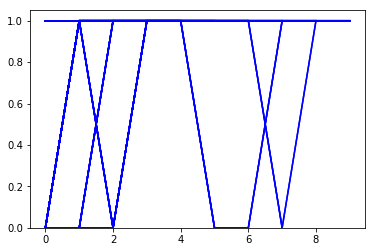

In [16]:
print("Percent of successful episodes: " + str(100.0 * sum(rList)/num_episodes) + "%")

plt.bar(range(len(rList)), rList, color = "Blue", width = 0.00001)
plt.show()